# Modelling

Import of packages

In [1]:
import pandas as pd
import numpy as np
import re
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, get_scorer_names, get_scorer, roc_auc_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


from sklearn.linear_model import LinearRegression


# imblearn for sampling
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline

# set random state for model results reproducibility
rng = 42

import warnings
warnings.filterwarnings('ignore') # hide warnings to avoid cluttering the notebook output

## Load datasets

In [2]:
train_df = pd.read_csv('../cleaned_dataset/cleaned_fe_train.csv')
test_df = pd.read_csv('../cleaned_dataset/cleaned_fe_test.csv')

In [39]:
test_df.head()

,block,latitude,longitude,addressaccuracy,tmax_stn1,tmin_stn1,depart_stn1,wetbulb_stn1,heat_stn1,cool_stn1,...,trap_t900,trap_t903,species_others,street_others,trap_others,daylight_duration,tavg_stn2_celsius,tavg_stn1_celsius,relative_humidity_stn2,relative_humidity_stn1
0,41,41.95469,-87.800991,9,86,61,7,64,0,9,...,0,0,0,0,0,1510,24.444444,23.333333,19.501463,17.393293
1,41,41.95469,-87.800991,9,86,61,7,64,0,9,...,0,0,0,0,0,1510,24.444444,23.333333,19.501463,17.393293
2,41,41.95469,-87.800991,9,86,61,7,64,0,9,...,0,0,0,0,0,1510,24.444444,23.333333,19.501463,17.393293
3,41,41.95469,-87.800991,9,86,61,7,64,0,9,...,0,0,0,0,0,1510,24.444444,23.333333,19.501463,17.393293
4,41,41.95469,-87.800991,9,86,61,7,64,0,9,...,0,0,0,0,0,1510,24.444444,23.333333,19.501463,17.393293


## Train Test Split

In [4]:
X = train_df.drop(['wnvpresent', 'nummosquitos'], axis=1)
y = train_df['wnvpresent']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50)


## Logistic Regression Baseline

In [5]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

lr.score(X_train, y_train)

0.947074501840335

In [6]:
lr.score(X_test, y_test)

0.9489912447658927

In [7]:
preds = lr.predict(X_test)
ROC_AUC = roc_auc_score(y_test, preds)
print('ROC AUC score:', round(ROC_AUC, 5))

ROC AUC score: 0.5


## Using SMOTE for oversampling

In [8]:
smt = SMOTE(random_state=50)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smt.fit_resample(X_test, y_test)

In [9]:
print(f'Shape before SMOTE: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Shape after SMOTE: X_train_sm: {X_train_sm.shape}, y_train_sm: {y_train_sm.shape}')

Shape before SMOTE: X_train: (7879, 308), y_train: (7879,)
Shape after SMOTE: X_train_sm: (14924, 308), y_train_sm: (14924,)


## Logistic Regression

In [10]:
lr = LogisticRegression()

lr.fit(X_train_sm, y_train_sm)

lr.score(X_train_sm, y_train_sm)

0.67877244706513

In [11]:
lr.score(X_test_sm, y_test_sm)

0.6941436020858404

In [12]:
#preds_sm_lr = lr.predict(X_test_sm)
probs_sm_lr = lr.predict_proba(X_test_sm)[:, 1]
#LR_ROC_AUC = roc_auc_score(y_test_sm, preds_sm_lr)
LR_ROC_AUC = roc_auc_score(y_test_sm, probs_sm_lr)
print('ROC AUC score:', round(LR_ROC_AUC, 5))



ROC AUC score: 0.76591


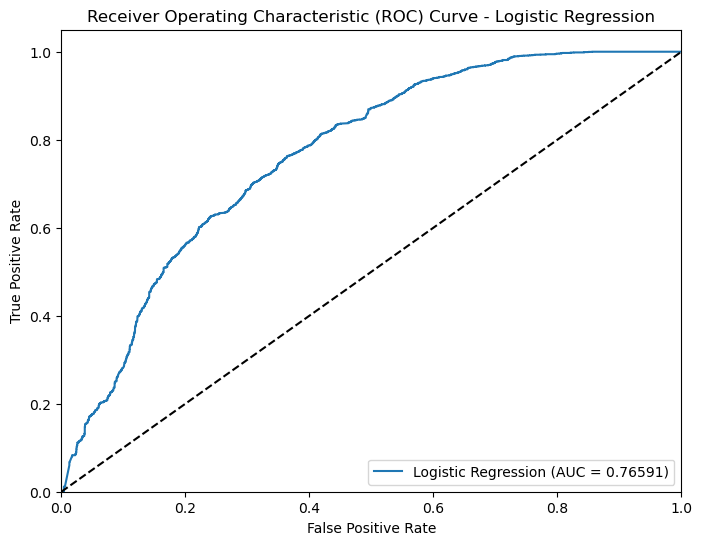

In [13]:
probs_sm_lr = lr.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC curve and AUC
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_sm, probs_sm_lr)
roc_auc_lr = roc_auc_score(y_test_sm, probs_sm_lr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = %0.5f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


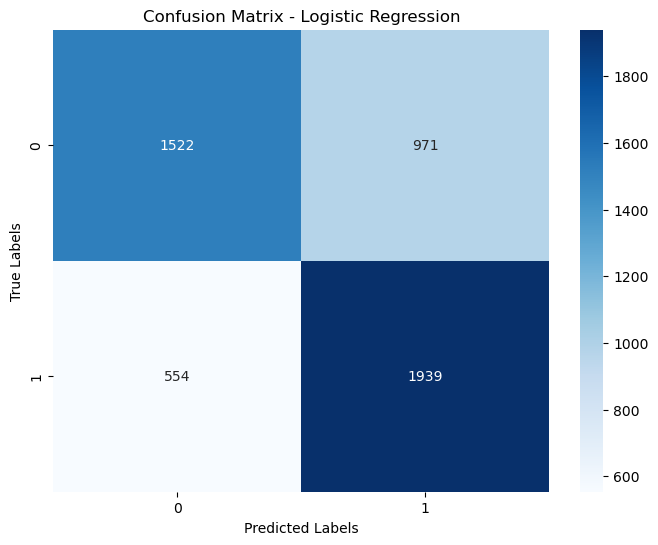

In [14]:
# Generate predictions
preds_sm_lr = lr.predict(X_test_sm)

# Create confusion matrix
cm = confusion_matrix(y_test_sm, preds_sm_lr)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Random Forest Modelling

In [15]:
# Fit and train Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_sm, y_train_sm)
rf_train_score = rf.score(X_train_sm, y_train_sm)
rf_test_score = rf.score(X_test_sm, y_test_sm)
preds_sm_rf = rf.predict(X_test_sm)

print("Train Score: ",rf_train_score)
print("Test Score: ",rf_test_score)

Train Score:  0.9837175020101849
Test Score:  0.8854793421580425


In [16]:
# Generate predicted probabilities
probs_sm_rf = rf.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC AUC score
RF_ROC_AUC = roc_auc_score(y_test_sm, probs_sm_rf)
print('ROC AUC score:', round(RF_ROC_AUC, 5))

ROC AUC score: 0.95427


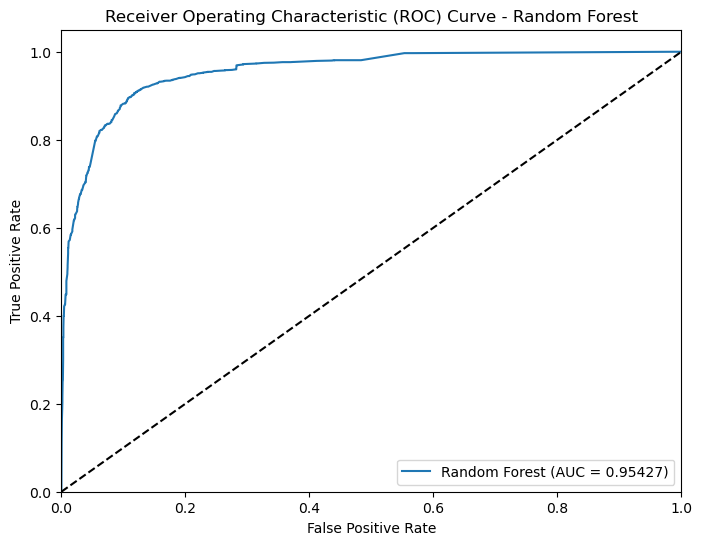

In [17]:
probs_sm_rf = rf.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_sm, probs_sm_rf)
roc_auc_rf = roc_auc_score(y_test_sm, probs_sm_rf)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = %0.5f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()


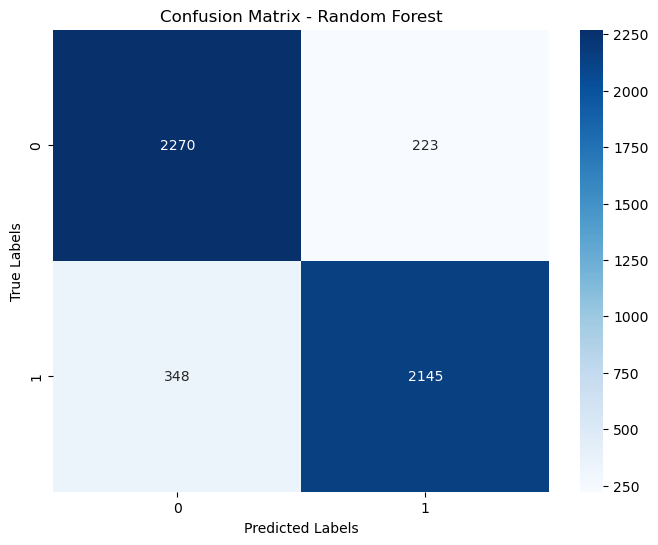

In [18]:
# Generate predictions
preds_sm_rf = rf.predict(X_test_sm)

# Create confusion matrix
cm = confusion_matrix(y_test_sm, preds_sm_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## AdaBoost

In [19]:
# Fit and train AdaBoost
ada = AdaBoostClassifier()
ada.fit(X_train_sm, y_train_sm)
ada_train_score = ada.score(X_train_sm, y_train_sm)
ada_test_score = ada.score(X_test_sm, y_test_sm)
print("Train Score: ",ada_train_score)
print("Test Score: ",ada_test_score)

Train Score:  0.8574108818011257
Test Score:  0.8880866425992779


In [20]:
# Generate predicted probabilities
probs_sm_ada = ada.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC AUC score
ADA_ROC_AUC = roc_auc_score(y_test_sm, probs_sm_ada)
print('ROC AUC score:', round(ADA_ROC_AUC, 5))

ROC AUC score: 0.94944


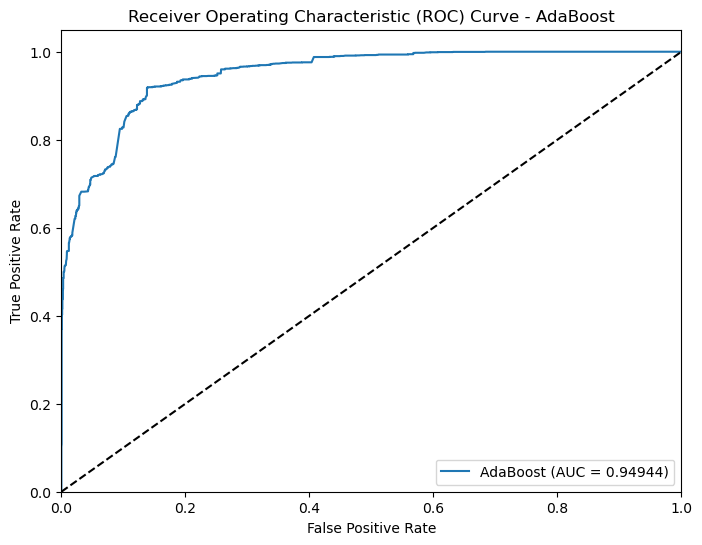

In [21]:
probs_sm_ada = ada.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC curve and AUC
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test_sm, probs_sm_ada)
roc_auc_ada = roc_auc_score(y_test_sm, probs_sm_ada)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ada, tpr_ada, label='AdaBoost (AUC = %0.5f)' % roc_auc_ada)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - AdaBoost')
plt.legend(loc='lower right')
plt.show()


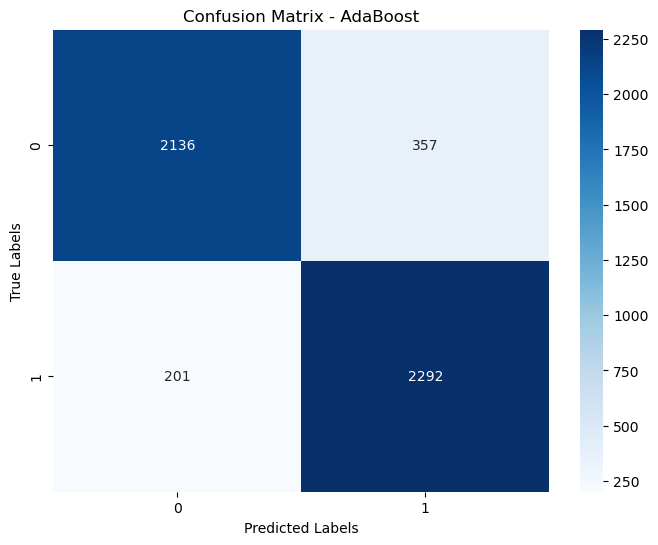

In [22]:
# Generate predictions
preds_sm_ada = ada.predict(X_test_sm)

# Create confusion matrix
cm = confusion_matrix(y_test_sm, preds_sm_ada)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - AdaBoost')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Gradient Boosting

In [23]:
# Fit and train Gradient Boosting
gb = GradientBoostingClassifier()
gb.fit(X_train_sm, y_train_sm)
gb_train_score = gb.score(X_train_sm, y_train_sm)
gb_test_score = gb.score(X_test_sm, y_test_sm)
print("Train Score: ",gb_train_score)
print("Test Score: ",gb_test_score)

Train Score:  0.8830742428303404
Test Score:  0.9019253910950662


In [24]:
# Generate predicted probabilities
probs_sm_gb = gb.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC AUC score
GB_ROC_AUC = roc_auc_score(y_test_sm, probs_sm_gb)
print('ROC AUC score:', round(GB_ROC_AUC, 5))

ROC AUC score: 0.96433


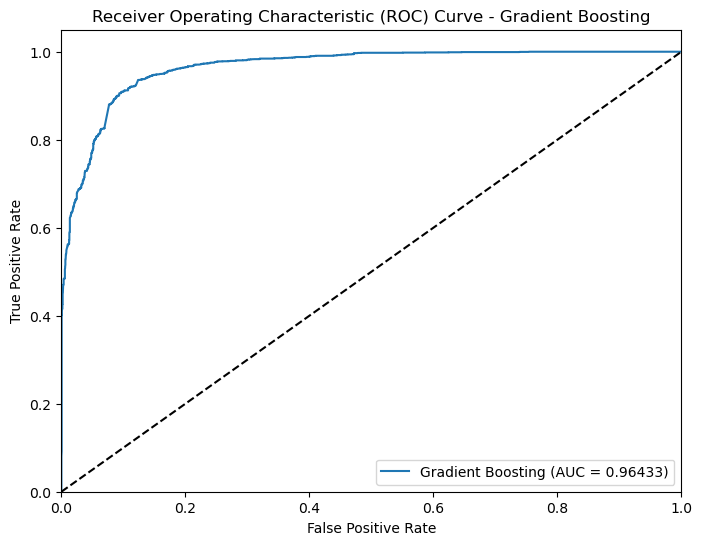

In [25]:
probs_sm_gb = gb.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC curve and AUC
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test_sm, probs_sm_gb)
roc_auc_gb = roc_auc_score(y_test_sm, probs_sm_gb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = %0.5f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()


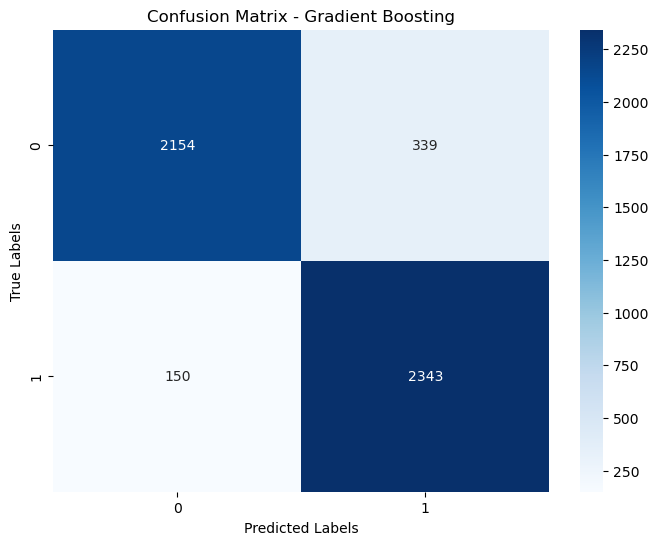

In [26]:
# Generate predictions
preds_sm_gb = gb.predict(X_test_sm)

# Create confusion matrix
cm = confusion_matrix(y_test_sm, preds_sm_gb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## Run Test data set for Kaggle Score


In [27]:
num_columns_X_test_sm = X_test_sm.shape[1]
num_columns_test_df = test_df.shape[1]

print("Number of columns in X_test_sm:", num_columns_X_test_sm)
print("Number of columns in test_df:", num_columns_test_df)

Number of columns in X_test_sm: 308
Number of columns in test_df: 308


In [28]:
column_names_X_test_sm = X_test_sm.columns.tolist()
column_names_test_df = test_df.columns.tolist()

if column_names_X_test_sm == column_names_test_df:
    print("The column names are in the same order.")
else:
    print("The column names are not in the same order.")


The column names are not in the same order.


In [29]:
test_df = test_df.reindex(columns=X_test_sm.columns)

In [30]:
column_names_X_test_sm = X_test_sm.columns.tolist()
column_names_test_df = test_df.columns.tolist()

if column_names_X_test_sm == column_names_test_df:
    print("The column names are in the same order.")
else:
    print("The column names are not in the same order.")



The column names are in the same order.


In [31]:
# Get the column names of X_test_sm and test_df
columns_X_test_sm = X_test_sm.columns
columns_test_df = test_df.columns

# Check if the columns are different
if set(columns_X_test_sm) != set(columns_test_df):
    # Columns are different
    different_columns = set(columns_X_test_sm) ^ set(columns_test_df)
    print("Different columns:", different_columns)
else:
    # Columns are the same
    print("Columns are the same")


Columns are the same


In [32]:
test_df_ori = pd.read_csv('../Kaggle Datasets/test.csv/test.csv')

In [33]:
test_df_ori.columns


Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')

In [34]:
X_test_sm.columns

Index(['block', 'latitude', 'longitude', 'addressaccuracy', 'tmax_stn1',
       'tmin_stn1', 'depart_stn1', 'wetbulb_stn1', 'heat_stn1', 'cool_stn1',
       ...
       'trap_T900', 'trap_T903', 'species_others', 'street_others',
       'trap_others', 'daylight_duration', 'tavg_stn2_celsius',
       'tavg_stn1_celsius', 'relative_humidity_stn2',
       'relative_humidity_stn1'],
      dtype='object', length=308)

In [35]:
test_df.columns = test_df.columns.str.lower()  # Convert column names to lowercase


In [ ]:
test_df.to_csv('test_df.csv', index=False)

In [36]:
from sklearn.impute import SimpleImputer

# Create an instance of SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the data and transform the data
X_imputed = imputer.fit_transform(test_df)

In [40]:
with open('../Streamlit/impute.pkl', 'wb') as file:
    pickle.dump(imputer, file)

In [38]:
df = pd.DataFrame(X_imputed)
df.to_csv('columns.csv', index=False)

In [ ]:

# Check if 'id' column exists in test_df
if 'Id' in test_df_ori.columns:
    preds_prob_test_gb = gb.predict_proba(X_imputed)[:, 1]

    # Create a DataFrame with the predictions
    submission_df = pd.DataFrame({'Id': test_df_ori['Id'], 'WnvPresent': preds_prob_test_gb})

    # Save the DataFrame to a CSV file
    submission_df.to_csv('submission.csv', index=False)
else:
    print("Column 'id' not found in test_df.")



## Hyperparameter Tuning

In [ ]:
# Set the best hyperparameters
best_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}

# Create the Gradient Boosting model with the best hyperparameters
gb_best = GradientBoostingClassifier(**best_params)

# Fit and train the model using the best hyperparameters
gb_best.fit(X_train_sm, y_train_sm)

# Evaluate the model on the training and test sets
gb_train_score = gb_best.score(X_train_sm, y_train_sm)
gb_test_score = gb_best.score(X_test_sm, y_test_sm)

print("Train Score: ", gb_train_score)
print("Test Score: ", gb_test_score)

Train Score:  0.9677700348432056
Test Score:  0.9306056959486563


In [ ]:
# Predict probabilities for the test set using gb_best
preds_prob_test_gb = gb_best.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC AUC score
gb_roc_auc = roc_auc_score(y_test_sm, preds_prob_test_gb)

print("ROC AUC Score: ", gb_roc_auc)

ROC AUC Score:  0.9792457790759171


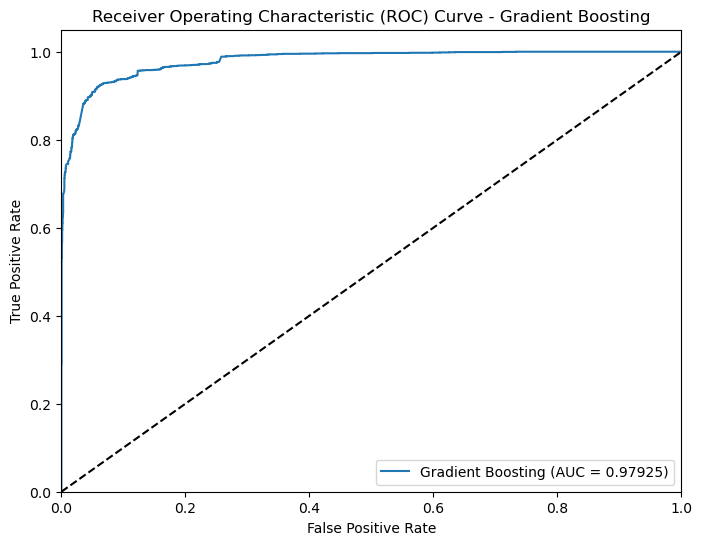

In [ ]:
probs_sm_gb = gb_best.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC curve and AUC
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test_sm, probs_sm_gb)
roc_auc_gb = roc_auc_score(y_test_sm, probs_sm_gb)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting (AUC = %0.5f)' % roc_auc_gb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()

## Score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Threshold for classification
threshold = 0.5

# Convert probabilities to binary predictions based on the threshold
preds_sm_gb = np.where(probs_sm_gb >= threshold, 1, 0)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_sm, preds_sm_gb)
recall = recall_score(y_test_sm, preds_sm_gb)
f1 = f1_score(y_test_sm, preds_sm_gb)
accuracy = accuracy_score(y_test_sm, preds_sm_gb)

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy Score:", accuracy)


Precision: 0.9408624229979466
Recall: 0.918973124749298
F1 Score: 0.929788961038961
Accuracy Score: 0.9306056959486563


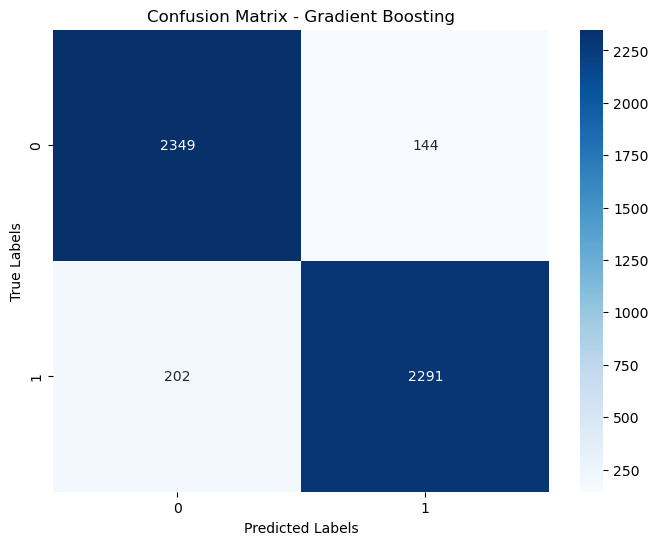

In [ ]:
# Generate predictions
preds_sm_gb = gb_best.predict(X_test_sm)

# Create confusion matrix
cm = confusion_matrix(y_test_sm, preds_sm_gb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



## Updated Kaggle Submission

In [ ]:
# Check if 'Id' column exists in test_df_ori
if 'Id' in test_df_ori.columns:
    preds_prob_test_gb = gb_best.predict_proba(X_imputed)[:, 1]

    # Create a DataFrame with the predictions
    submission_df = pd.DataFrame({'Id': test_df_ori['Id'], 'WnvPresent': preds_prob_test_gb})

    # Save the DataFrame to a CSV file
    submission_df.to_csv('../Kaggle Submission/kaggle_submission.csv', index=False)
else:
    print("Column 'Id' not found in test_df_ori.")

Pickle File export

In [ ]:
# Save the model as a pickle file
filename = '../Streamlit/gb_best_model_updated.pkl'
with open(filename, 'wb') as file:
    pickle.dump(gb_best, file)

## Feature Importance

In [ ]:
importance = gb_best.feature_importances_
feature_names = X_train_sm.columns

# Create a DataFrame with feature names and importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Print the top feature importances
top_feature_importances = feature_importances_df.head(20)
print(top_feature_importances)


                            Feature  Importance
303               daylight_duration    0.297187
32            species_CULEX PIPIENS    0.082720
34           species_CULEX RESTUANS    0.078189
2                         longitude    0.065655
33   species_CULEX PIPIENS/RESTUANS    0.055684
1                          latitude    0.032619
29                             year    0.032540
3                   addressaccuracy    0.027951
0                             block    0.026789
12                 preciptotal_stn1    0.024507
37          species_CULEX TERRITANS    0.020067
17                    avgspeed_stn1    0.018909
26                 resultspeed_stn2    0.015231
23                 preciptotal_stn2    0.015111
306          relative_humidity_stn2    0.014146
31                              day    0.014000
13                 stnpressure_stn1    0.011913
307          relative_humidity_stn1    0.009949
305               tavg_stn1_celsius    0.008586
15                 resultspeed_stn1    0

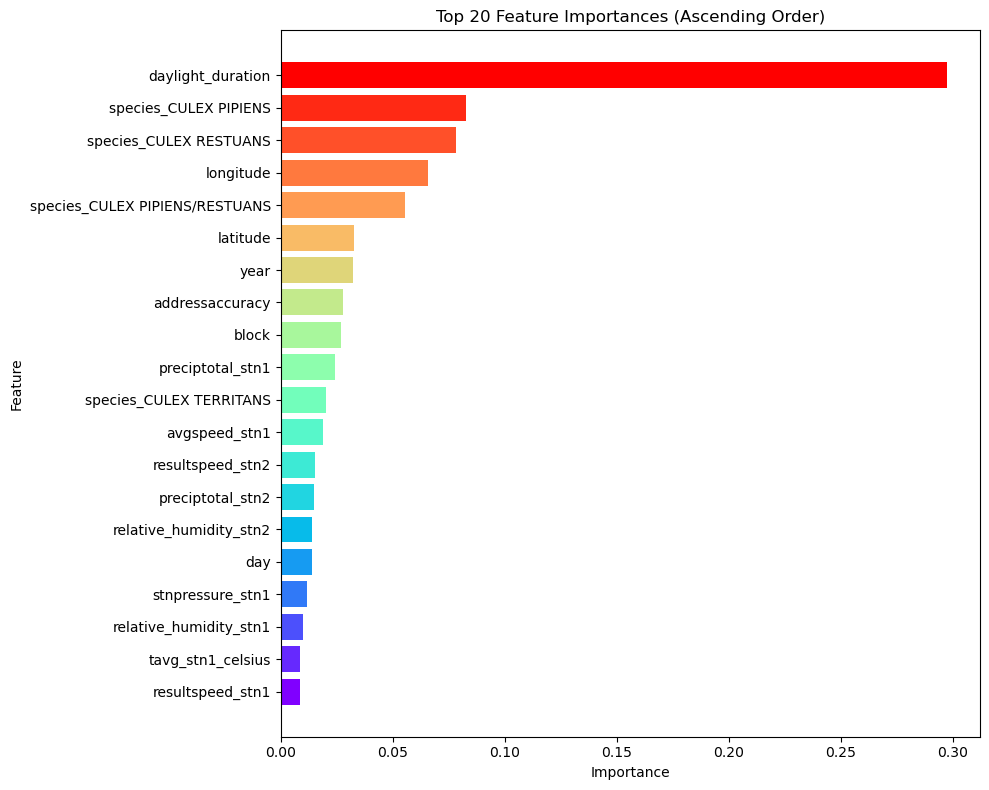

In [ ]:
# Sort the top feature importances by importance value in ascending order
top_feature_importances.sort_values(by='Importance', ascending=True, inplace=True)

# Select the top 20 features
top_20_features = top_feature_importances.tail(20)

# Create a colormap for the bars
colors = plt.cm.rainbow(np.linspace(0, 1, len(top_20_features)))

# Plot the top 20 feature importances in a horizontal bar chart with rainbow-colored bars
plt.figure(figsize=(10, 8))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances (Ascending Order)')
plt.tight_layout()
plt.show()


## Shapely

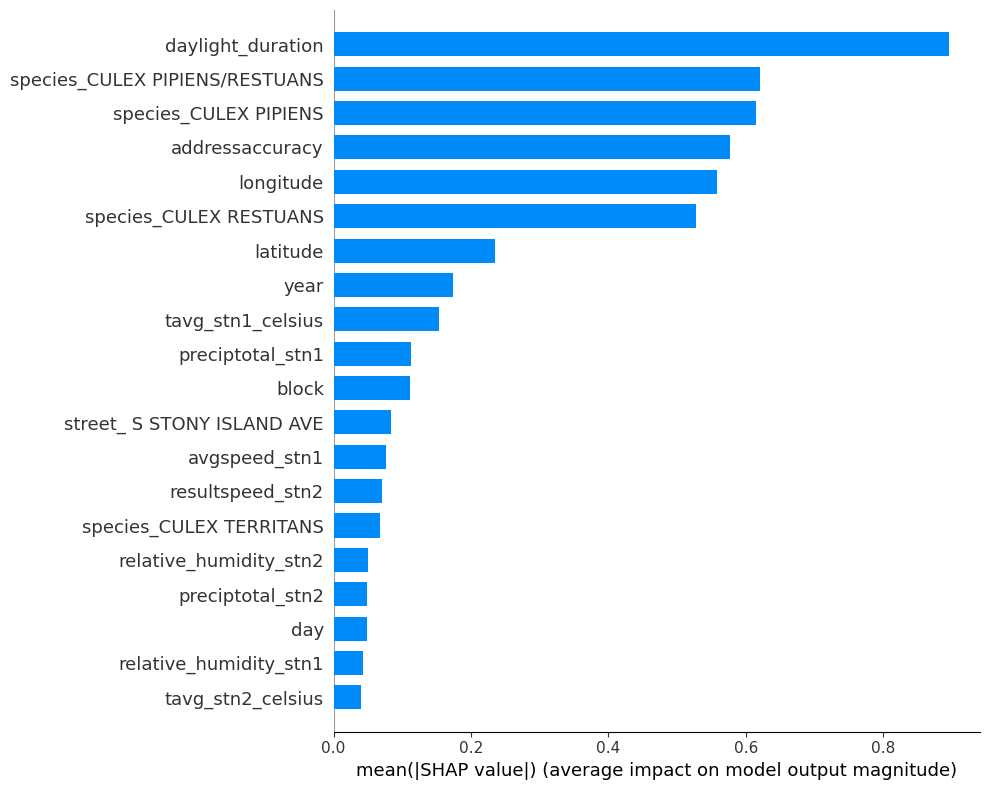

In [ ]:
import shap

# Initialize the SHAP explainer with the trained Gradient Boosting model
explainer = shap.Explainer(gb_best)

# Calculate the Shapley values for a sample of data (e.g., X_test_sm)
shap_values = explainer.shap_values(X_test_sm)

# Visualize the Shapley values
shap.summary_plot(shap_values, X_test_sm, plot_type="bar", plot_size=(10, 8))
